In [1]:
import healpy as hp
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from glob import glob
from astropy.table import Table, vstack

In [2]:
import sys
sys.path.append('/global/homes/a/arosado/LSSutils/')
from lssutils import setup_logging, CurrentMPIComm
from lssutils.lab import get_meandensity
from lssutils.utils import npix2nside, make_hp
from lssutils.utils import maps_dr9 as columns

In [3]:
print(columns)

['EBV', 'STARDENS', 'galdepth_rmag_ebv', 'galdepth_gmag_ebv', 'galdepth_zmag_ebv', 'psfdepth_rmag_ebv', 'psfdepth_gmag_ebv', 'psfdepth_zmag_ebv', 'psfdepth_w1mag_ebv', 'psfdepth_w2mag_ebv', 'PSFSIZE_R', 'PSFSIZE_G', 'PSFSIZE_Z']


# Mean Density

feature: EBV
BMZLS
running 100/100
finished at 179.73 s


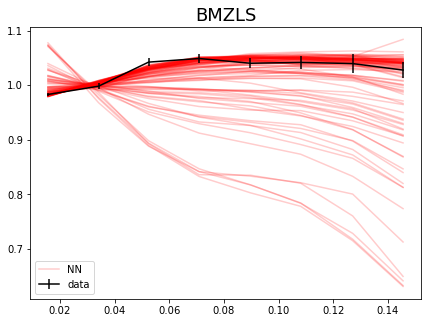

NDECALS
running 100/100
finished at 171.21 s


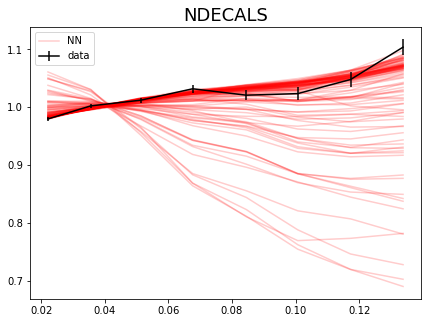

SDECALS
running 100/100
finished at 171.66 s


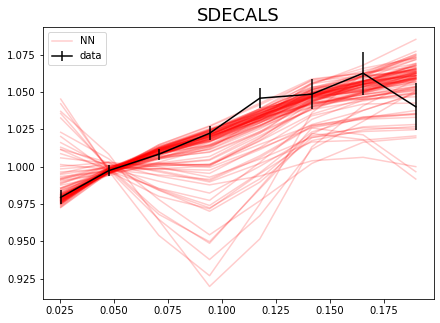

In [4]:
from time import time

regions = ['bmzls', 'ndecals', 'sdecals']
windows = dict()
data = dict()
for region in regions:
    windows[region] = glob(f'/global/cscratch1/sd/arosado/test_sysnet/{region}_256/windows/window_model_*fits')
    data[region] = glob(f'/global/cscratch1/sd/arosado/nlrg_features_{region}_256.fits')

nside = 256
col_i = 0 # EBV
print(f'feature: {columns[col_i]}')

for region in regions:
    print(region.upper())
    d_ = ft.read(data[region][0])
    ngal = d_['label']
    nran = d_['fracgood']
    mask = np.ones_like(ngal, '?')
    sysm = d_['features']
    hpix = d_['hpix']
    nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                                 columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                                 global_nbar=True, njack=20)

    output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/{region}_256/results'



    fig = plt.gcf()
    fig.set_size_inches(7, 5)

    t0 = time()
    for i in range(100):
        print(f'running {i+1}/100', end='\r', flush=True)

        w_ = ft.read(windows[region][i])
        nn = make_hp(nside, w_['hpix'], w_['weight'])[hpix]

        nnbar_ls= get_meandensity(nran*nn, nran, mask, sysm, 
                                  columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                                  global_nbar=True)

        plt.plot(nnbar_ls[col_i]['bin_avg'], nnbar_ls[col_i]['nnbar'], alpha=0.2, color='r')

        output_fn = f'{output_dir}/nnbar_list_{region}_{i}.hp256.npy'
        #print(end='\n')
        #print(f'saving {output_fn}')
        #np.save(output_fn, nnbar_ls)
        #print(f'time elapsed {time()-t0} s')
    print(end='\n')
    print(f'finished at {time()-t0:.2f} s')

    plt.plot([],[],alpha=0.2, color='r', label='NN')
    plt.errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'],nnbar_list[col_i]['nnbar_err'], color='k', label='data')
    plt.title(f'{region.upper()}', fontsize=18)
    plt.legend()
    plt.show()

## Compare data to NN results 

feature: EBV
BMZLS
running 100/100
finished at 0.48 s


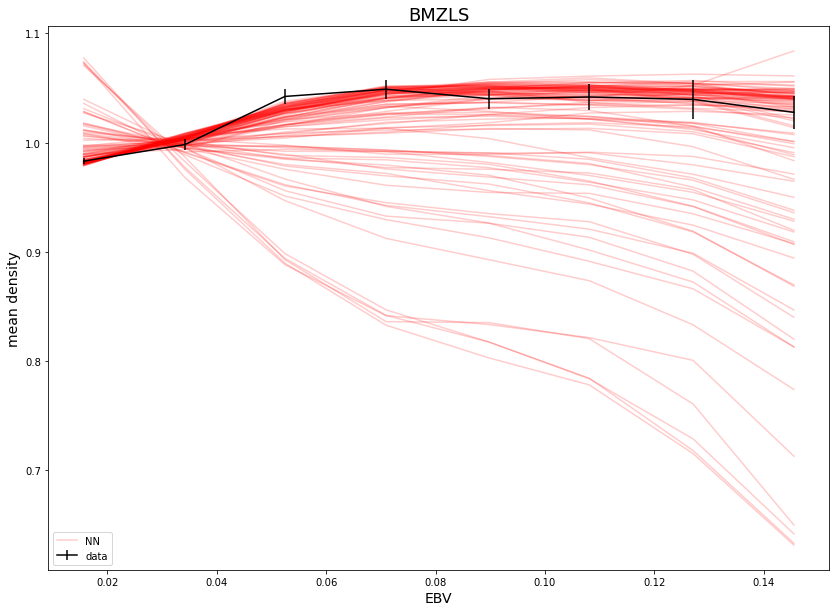

NDECALS
running 100/100
finished at 0.24 s


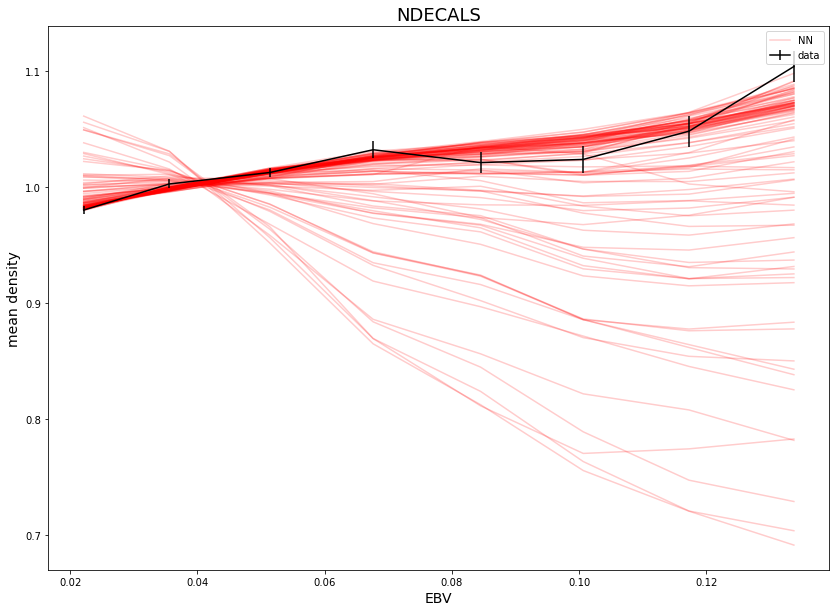

SDECALS
running 100/100
finished at 0.20 s


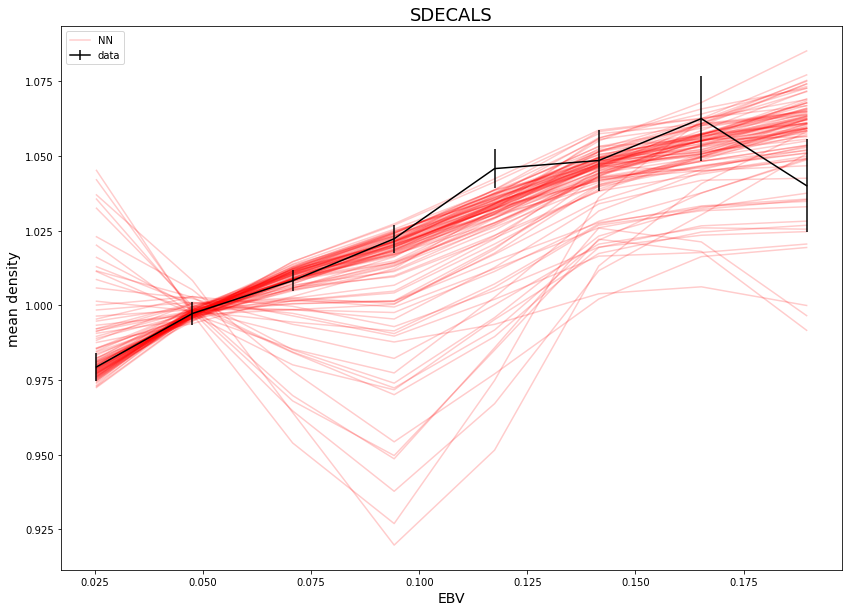

In [5]:
from time import time

regions = ['bmzls', 'ndecals', 'sdecals']
data = dict()
for region in regions:
    data[region] = glob(f'/global/cscratch1/sd/arosado/nlrg_features_{region}_256.fits')

nside = 256
col_i = 0 # EBV
print(f'feature: {columns[col_i]}')

for region in regions:
    print(region.upper())
    d_ = ft.read(data[region][0])
    ngal = d_['label']
    nran = d_['fracgood']
    mask = np.ones_like(ngal, '?')
    sysm = d_['features']
    hpix = d_['hpix']
    nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                                 columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                                 global_nbar=True, njack=20)

    output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/{region}_256/results'

    fig = plt.gcf()
    fig.set_size_inches(14, 10)

    t0 = time()
    for i in range(100):
        print(f'running {i+1}/100', end='\r')

        nnbar_ls= np.load(f'{output_dir}/nnbar_list_{region}_{i}.hp256.npy', allow_pickle=True)

        plt.plot(nnbar_ls[col_i]['bin_avg'], nnbar_ls[col_i]['nnbar'], alpha=0.2, color='r')

    print(end='\n')
    print(f'finished at {time()-t0:.2f} s')

    plt.plot([],[],alpha=0.2, color='r', label='NN')
    plt.errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'],nnbar_list[col_i]['nnbar_err'], color='k', label='data')
    plt.title(f'{region.upper()}', fontsize=18)
    plt.ylabel(r'mean density', fontsize=14)
    plt.xlabel(f'{columns[col_i]}', fontsize=14)
    plt.legend()
    plt.show()